In [1]:
import numpy as np
import sympy

from sympy.functions.special.tensor_functions import LeviCivita
from scipy.integrate import solve_ivp, solve_bvp

%matplotlib notebook
import matplotlib.pyplot as plt

from einsteinpy.symbolic import MetricTensor, GenericVector, ChristoffelSymbols, MetricTensor
from einsteinpy.symbolic.predefined import Schwarzschild, Minkowski, Kerr

def substitute_in_vector(x, subs, coords, config='u'):
    """
    TODO:
        - documentation
        - clean up
    """
    xsubbed = [0] * x.dims

    xtensor = x.tensor()

    for i in range(x.dims):
        xsubbed[i] = xtensor[i].subs(subs)

    return GenericVector(xsubbed, coords, config=config)

In [20]:
metric_type = 'Schwarzschild'

In [21]:
t, theta, phi = sympy.symbols('t theta phi', real=True)
r = sympy.Symbol('r', real=True, positive=True)
coords = (t, r, theta, phi)
c, r_s, a = sympy.symbols('c r_s a', real=True)


Sigma = r**2 + a**2 * sympy.cos(theta)**2
Delta = r**2 - r_s * r + a**2
A = (r**2 + a**2)**2 - a**2 * Delta * sympy.sin(theta)**2


metric = [[- (1 - r_s * r / Sigma), 0, 0, -r_s * a * r * sympy.sin(theta)**2 / Sigma],
          [0, Sigma / Delta, 0, 0],
          [0, 0, Sigma, 0],
          [-r_s * a * r * sympy.sin(theta)**2 / Sigma, 0, 0, A * sympy.sin(theta)**2 / Sigma]]

metric = MetricTensor(metric, coords)

if metric_type == 'Kerr':
    e0 = GenericVector([(r**2 + a**2) / sympy.sqrt(Sigma * Delta), 0, 0, a / sympy.sqrt(Sigma * Delta)], coords,
                       parent_metric=metric)
elif metric_type == 'Schwarzschild':
    metric = metric.subs({a: 0})
    metric = metric.simplify()
    metric = MetricTensor(metric, coords)
    e0 = GenericVector([1 / sympy.sqrt(1 - r_s / r), 0, 0, 0], coords, parent_metric=metric)

else:
    raise KeyError("Unsupported metric {}".format(metric_type))
    
t = e0

In [25]:
class SymbolicCalculator:
    
    def __init__(self, metric, t):
        self.metric = metric
        self._invg = metric.inv()
        
        # Spacetime coordinate and p_mu symbols
        self.coords = metric.symbols()
        self.p_symbols = tuple(sympy.symbols(['p_{}'.format(par) for par in self.coords]))
        # All symbols along with the metric variables
        self.symbols = self.coords + self.p_symbols + tuple(self.metric.variables)
        
        self.Ndim = self.metric.dims
        # Symbolic expressions for x^\mu and p_\mu
        self.x = GenericVector(self.coords, self.coords, config='u', parent_metric=self.metric)
        self.p = GenericVector(self.p_symbols, self.coords, config='l', parent_metric=self.metric)
        
        self.t = t
        
        self.eps = sympy.symbols('epsilon')
        
    @property
    def partial_invg(self):
        """
        The partial derivatives of the inverse metric,
        
        .. math::
        
            \partial_\mu \tensor{g}{^\alpha ^\beta}.
        """
        partial_invg = np.zeros((self.Ndim, self.Ndim, self.Ndim), dtype=int).tolist()
        invg = self._invg
  
        for mu in range(self.Ndim):
            for alpha in range(self.Ndim):
                for beta in range(self.Ndim):
                    partial_invg[mu][alpha][beta] = sympy.diff(invg[alpha, beta], self.coords[mu])
        return partial_invg
 
    @property
    def xdot(self):
        """
        The derivative of the ray coordinate with respect to the affine parameter,
        
        .. math::
        
            \dot{x}^\mu = \tensor{g}{^\mu ^\nu} p_\nu.
        """
        invg = self._invg
        p = self.p
        
        xdot = [0] * self.Ndim
        for mu in range(self.Ndim):
            for nu in range(self.Ndim):
                xdot[mu] += invg[mu, nu] * p[nu]
        # Wrap this in a tensor-like expression
        return GenericVector(xdot, self.coords)

    @property
    def pdot(self):
        """
        The derivative of the :math:`p_\nu` covector with respect to the affine parameter,
        
        .. math::
            \dot{p}_\mu = - \frac{1}{2} \partial_\mu \tensor{g}{^\alpha ^\beta} p_{\alpha} p_{\beta}.
        """
        pdot = [0] * self.Ndim
        p = self.p
        
        p_invg = self.partial_invg
        for mu in range(self.Ndim):
            for alpha in range(self.Ndim):
                for beta in range(self.Ndim):
                    pdot[mu] +=  p_invg[mu][alpha][beta] * p[alpha] * p[beta]
            pdot[mu] *= -sympy.Rational(1, 2)
        # Wrap this in a tensor-like expression
        return GenericVector(pdot, self.coords)
    
    
    @property
    def p0(self):
        """
        Returns the zeroth coordinate of the :math:`p_\nu` covector,
        
        .. math::
            p_0 = 1 / \tensor{g}{^0 ^0}
              * \left(
                  - \tensor{g}{^0 ^i} p_i
                  + \sqrt{(\tensor{g}{^0 ^i} p_i)^2 - \tensor{g}{^0 ^0} \tensor{g}{^i ^j} p_i p_j
              \right),
              
        assumig that :math:`p_\alpha p^\alpha = 0`. Note that this only containts the
        :math:`\epsilon^0` contribution, check again why that is.
        """
        
        invg = self._invg
        N = self.Ndim
        p = self.p
        
        
        part1 = - sum(invg[0, i] * p[i] for i in range(1, N))
        part2 = sympy.sqrt(
            sum(invg[0, i] * p[i] for i in range(1, N))**2
            - invg[0, 0] * sum(invg[i, j] * p[i] * p[j]
                               for j in range(1, N) for i in range(1, N)))
        
        
        return (part1 + part2) / self._invg[0, 0]

In [26]:
calc = SymbolicCalculator(metric, e0)

In [27]:
t = e0


In [28]:
t.tensor()

[1/sqrt(1 - r_s/r), 0, 0, 0]

In [167]:
args, func = t.tensor_lambdify()
args

(t, r, theta, phi, r_s)

In [168]:
func(0, 3, 0, 0, 2)

[1.7320508075688772, 0, 0, 0]

In [144]:
t.change_config('l').tensor()

[-sqrt(r*(r - r_s))/Abs(r), 0, 0, 0]

In [6]:
class RayObserver(SymbolicCalculator):
    """
    TODO:
        - documentation
        - clean up
    """
    

    @property
    def xdot(self):
        
        xdot0 = super().xdot
        p_0 = self.p_0
        
        
        xdot = [None] * (self.Ndim)
        for i in range(self.Ndim):
            xi = xdot0[i]# / norm
            xi = xi.subs(self.p_symbols[0], p_0)
            
            xdot[i] = xi
        
        return GenericVector(xdot, self.coords)
    
    @property
    def pdot(self):
        pdot0 = super().pdot
        
        p_0 = self.p_0
        
        pdot = [None] * (self.Ndim - 1)
        for i in range(self.Ndim - 1):
            pi = pdot0[i + 1] #/ norm
            
            pi = pi.subs(self.p_symbols[0], p_0)
            pdot[i] = pi
        
        return GenericVector(pdot, self.coords[1:])

In [7]:
class LambdifyTensor:
    
    def __init__(self, tensor, symbols):
        
        args, self.lmbda = tensor.tensor_lambdify()
        print(args, symbols)
        self.ordering = list(symbols.index(arg) for arg in args)
        
    def __call__(self, x):
        xhere = x[self.ordering]
        return self.lmbda(*xhere)

In [8]:
calc = SymbolicCalculator(metric)

ray_observer = RayObserver(metric)
syms = list(ray_observer.symbols)
__ = [syms.pop(i) for i in [ray_observer.Ndim]]
symbols = tuple(syms)

xdot_lmbda = LambdifyTensor(ray_observer.xdot, symbols)
pdot_lmbda = LambdifyTensor(ray_observer.pdot, symbols)

(t, r, theta, phi, p_phi, p_r, p_theta) (t, r, theta, phi, p_r, p_theta, p_phi)
(r, theta, phi, p_phi, p_r, p_theta) (t, r, theta, phi, p_r, p_theta, p_phi)


In [11]:
def numerical_xdot_pdot(t, args):
    xdot = xdot_lmbda(args)
    pdot = pdot_lmbda(args)
    # These returns list so the addition is not 
    # pointwise, but the syntax is unclear.
    return xdot + pdot

In [12]:
t_span = (0, 5000)
t = np.linspace(t_span[0], t_span[1], 5000)

# x0 = [0, 5, np.pi/2, 0]
# p0 = [0, 0.0, 0.5]
# initial_conditions = x0 + p0

initial_conditions = [2.34125117e+02, 2.18536863e+02, np.pi/2, -2.63620790e+00,
                      +8.91847131e-02, 0,  5.00000000e-01]
print(initial_conditions)

[234.125117, 218.536863, 1.5707963267948966, -2.6362079, 0.0891847131, 0, 0.5]


In [13]:
sol = solve_ivp(numerical_xdot_pdot, t_span, initial_conditions, dense_output=True, t_eval=t, )

r = sol['y'][1, :]
theta = sol['y'][2, :]
phi = sol['y'][3, :]

t = sol['t']
x = r * np.cos(phi) * np.sin(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(theta)
print(z.shape)

(5000,)


<IPython.core.display.Javascript object>


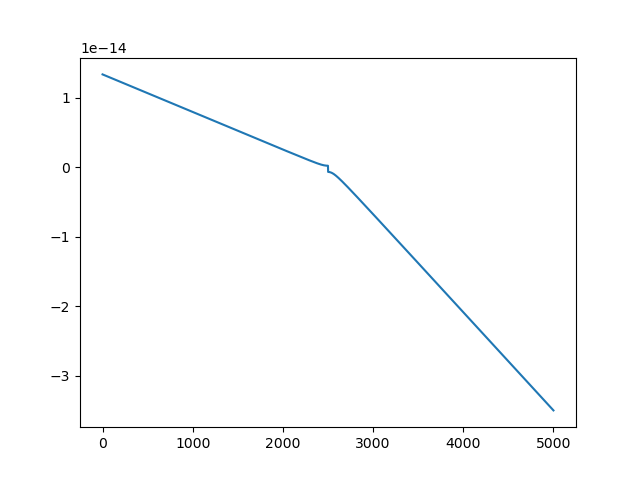

In [14]:
plt.figure()
plt.plot(t, z)
plt.show()

<IPython.core.display.Javascript object>


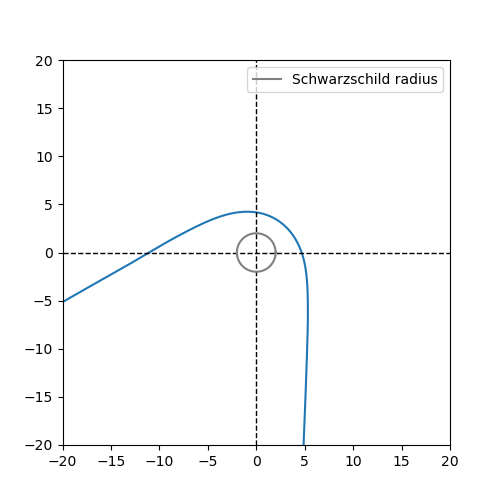

In [16]:
plt.figure(figsize=(5, 5))
plt.plot(x, y)

plt.axvline(0, c='black', ls='--', lw=1)
plt.axhline(0, c='black', ls='--', lw=1)


plt.xlim(-20, 20)
plt.ylim(-20, 20)

# Draw a circle of radius 2
t = np.linspace(0, 2*np.pi, 1000)
xc = 2 * np.cos(t)
yc = 2 * np.sin(t)

plt.plot(xc, yc, label='Schwarzschild radius', c='gray')
plt.legend()
plt.savefig('/Users/richard/Downloads/geodesic.png', dpi=240)
plt.show()